In [21]:
##############IMPORTS###################
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import re
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [34]:
##### Crawler Class

##Parser
def parse(string):
    lst = []
    tmp = ''
    for i in string:
        if '0'<=i<='9' or i == '.':
            tmp += i
        else:
            if i == ',' or tmp == '':
                continue
            lst.append(tmp)
            tmp = ''
    lst.append(tmp)
    return (lst)

class Crawler:
    def __init__(self, keyword):
        options = Options()
        self.page_count = 1

        #지정한 user-agent로 설정합니다.
        user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36"
        options.add_argument('user-agent=' + user_agent)
        self.driver = webdriver.Chrome("./chromedriver", options=options)
        self.url = 'https://map.naver.com/v5/search/' + keyword
        self.driver.get(self.url)
        self.driver.implicitly_wait(10)
    
    def scrape(self, n=30):
        self.infos = []
        try:
            self.driver.implicitly_wait(10)
            count = 0
            element = self.driver.find_element_by_id("searchIframe") #iframe 태그 엘리먼트 찾기
            self.driver.switch_to.frame(element) #프레임 이동

            
            while count < n:
                self.driver.implicitly_wait(10)
                html = self.driver.page_source
                soup = BeautifulSoup(html, 'html.parser')
                li_lst = soup.body.find_all('li')
                if count==0:
                    li_lst = li_lst[2:]
                if len(li_lst) == 0:
                    continue
                for elem in li_lst:
                    div_lst = elem.find('a').find_all('div')
                    if len(div_lst) == 0:
                        break
                    name = div_lst[0].find('span').text
                    nums = parse(div_lst[-1].text)
                    if len(nums) < 3:
                        continue
                    star, tot_review, visit_review, blog_review = nums[0], int(nums[1]) + int(nums[2]), nums[1], nums[2]

                    if len(div_lst) == 5:
                        description = div_lst[2].text
                    elif len(div_lst) == 7:
                        description = div_lst[2].text + ", " + div_lst[4].text
                    else:
                        description = 'No Desc.'
                    
                    self.infos.append([name, star, description, tot_review, visit_review, blog_review])
                    count += 1
                    if count == n:
                        break
                if count == n:
                    break
                self.driver.find_element(By.XPATH, '//*[@id="app-root"]/div/div/div[2]/a[7]').click()
                self.page_count += 1
                if self.page_count == 6:
                    break
            self.driver.quit()
            return (self.infos)
                

        except Exception as e:
            print(e)
            self.driver.quit()
            print("오류가 발생했습니다. 다시 시도해주세요.")
                
        

In [35]:
##### Getting URL
print("데이트코스를 찾아볼 지역을 입력하세요. ex) 연남동 카페")
print("input>> ", end = ' ')
loc = input().replace(' ', '+')
print("30개 장소 데이터를 가져옵니다.")
cw = Crawler(loc)
data = cw.scrape()

데이트코스를 찾아볼 지역을 입력하세요. ex) 연남동 카페
input>>  신사동 카페
30개 장소 데이터를 가져옵니다.


<ipython-input-34-75f088390800>:26: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self.driver = webdriver.Chrome("./chromedriver", options=options)
<ipython-input-34-75f088390800>:36: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  element = self.driver.find_element_by_id("searchIframe") #iframe 태그 엘리먼트 찾기


# 데이터 시각화

In [67]:
#### Showing Datas

df = pd.DataFrame(data)
df.columns = ['가게 이름', '별점', '설명', '총 리뷰', '방문 리뷰', '블로그 리뷰']
df.index += 1
df    


,가게 이름,별점,설명,총 리뷰,방문 리뷰,블로그 리뷰
1,아우어베이커리 가로수길점,4.46,"TV밥블레스유 방영, 전지적참견시점 이영자맛집 빵이 맛있는 아우어베이커리",4896,3075,1821
2,타르틴베이커리 도산점,4.38,No Desc.,2471,1651,820
3,샌드커피 논탄토 신사,4.47,No Desc.,1369,611,758
4,카페 노티드 청담,4.44,No Desc.,20704,15054,5650
5,르브런쉭 신사점,4.34,"TV미식클럽 방영, 가로수길파스타 가로수길브런치로 유명한 르브런쉭 가로수길점",1416,618,798
6,마망갸또 신사점,4.36,카라멜 롤 케이크가 유명한 디저트카페,910,220,690
7,빈터커피로스터스,4.57,신사역 카페 가로수길 카페 아인슈페너가 맛있는 빈터커피,501,329,172
8,식물학,4.43,"TV2TV생생정보 방영, 신사역 가로수길 커피가 맛있는 식물원 분위기 맛집",1620,582,1038
9,이치서울,4.37,쑥 라떼가 맛있는 가로수길 신상 카페,510,177,333
10,카페 키츠네 서울,4.26,No Desc.,677,373,304


# 2. 리뷰 수에 대한 별점

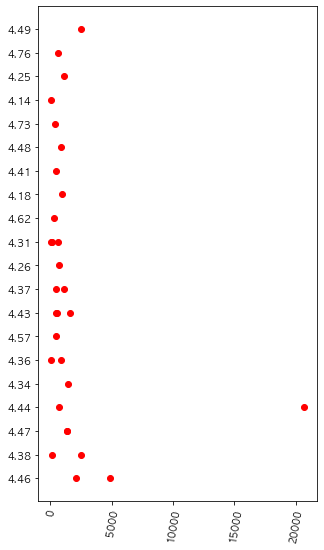

In [69]:
plt.figure(figsize=(5,20))

x2 = list(df['총 리뷰'])
y2 = list(df['별점'])
plt.subplot(2, 1, 2)
plt.xticks(rotation=80)
plt.scatter(x2, y2, color='red')

